In [1]:
## Este ejemplo hace detección de objetos mediante Object Detection API utilizando el modelo 
## faster_rcnn_resnet101_coco_2018_01_28

## La instalación de object detection está en el archivo readme del raíz.

## El link para obtener modelos entrenados es: 
## https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
## y el archivo de labels para la clasificación es el que viene con la instalación de Object Detection API
## de Tensorflow.

In [2]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("models/research/")
from object_detection.utils import ops as utils_ops

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

models/research/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


In [4]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.

#PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_NAME, 'frozen_inference_graph.pb')
PATH_TO_CKPT = os.path.join('/Users/sapo/Development/workspace-python/faster_rcnn_resnet101_coco_2018_01_28/', 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join(CWD_PATH, 'data', 'label.pbtxt')
PATH_TO_LABELS = os.path.join(CWD_PATH, 'movil_model/data', 'mscoco_label_map.pbtxt')


In [5]:
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [38]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=10)
    return image_np


In [7]:
# First test on images
PATH_TO_TEST_IMAGES_DIR = 'movil_model/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.JPEG'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(400, 300) (300, 400, 3)
(400, 300) (300, 400, 3)
(225, 300) (300, 225, 3)


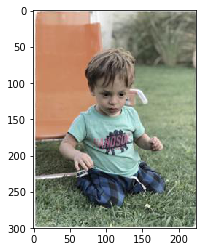

In [9]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [10]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(300, 400, 3)
(300, 400, 3)
(300, 225, 3)


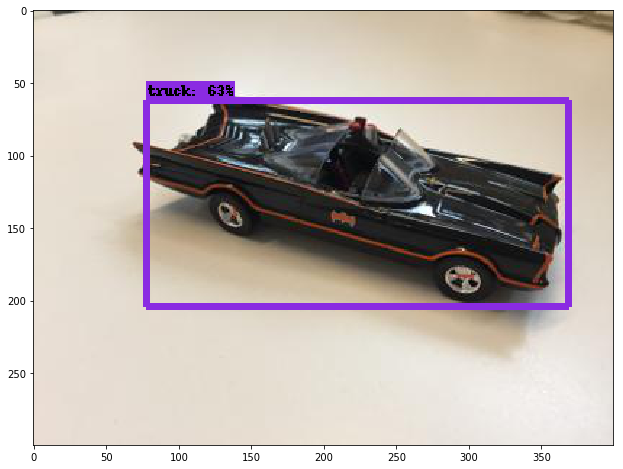

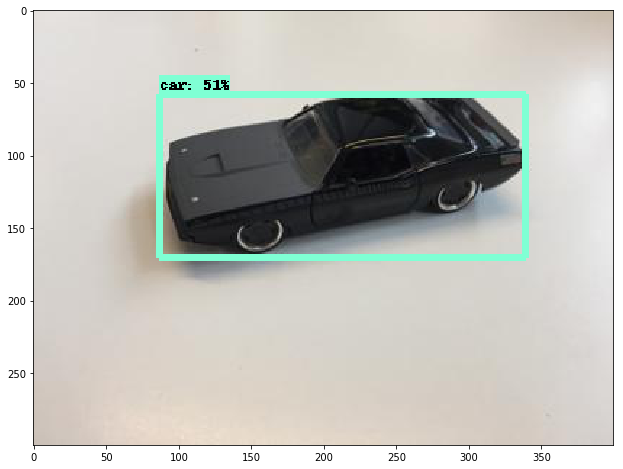

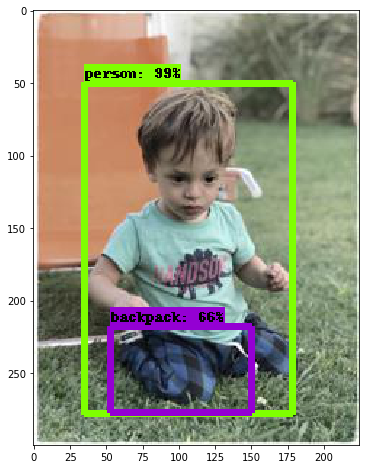

In [11]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#imageio.plugins.ffmpeg.download()

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

In [23]:
white_output = 'videos/benja_out.mp4'
clip1 = VideoFileClip("videos/benja.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos/benja_out.mp4
[MoviePy] Writing video videos/benja_out.mp4



100%|██████████| 60/60 [20:01<00:00, 15.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/benja_out.mp4 

CPU times: user 21min 52s, sys: 3min 57s, total: 25min 49s
Wall time: 20min 4s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [29]:
white_output1 = 'videos/athos_out.mp4'
clip1 = VideoFileClip("videos/athos.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output1, audio=False)

[MoviePy] >>>> Building video videos/athos_out.mp4
[MoviePy] Writing video videos/athos_out.mp4



100%|██████████| 60/60 [32:41<00:00, 18.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/athos_out.mp4 

CPU times: user 21min 56s, sys: 4min 3s, total: 26min
Wall time: 32min 45s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output1))

In [34]:
white_output2 = 'videos/living_out.mp4'
clip1 = VideoFileClip("videos/living.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video videos/living_out.mp4
[MoviePy] Writing video videos/living_out.mp4



100%|██████████| 60/60 [17:03<00:00, 17.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/living_out.mp4 

CPU times: user 22min 4s, sys: 4min 10s, total: 26min 15s
Wall time: 17min 6s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))

In [37]:
# Merge videos
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("videos/benja_out.mp4")
clip2 = VideoFileClip("videos/athos_out.mp4")
clip3 = VideoFileClip("videos/living_out.mp4")
final_clip = concatenate_videoclips([clip1,clip2,clip3], method="compose")
final_clip.write_videofile("my_concatenation.mp4",bitrate="5000k")

[MoviePy] >>>> Building video my_concatenation.mp4
[MoviePy] Writing video my_concatenation.mp4



100%|██████████| 180/180 [00:14<00:00, 16.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_concatenation.mp4 



In [39]:
from moviepy.editor import *
clip = VideoFileClip("videos/my_concatenation.mp4")
clip.write_gif("videos/final.gif")


[MoviePy] Building file final.gif with imageio



 86%|████████▌ | 155/181 [00:56<00:09,  2.68it/s]


 99%|█████████▉| 180/181 [01:06<00:00,  2.32it/s]WARNING:py.warnings:/Users/sapo/Development/workspace-python/cvtest/cvtest/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file my_concatenation.mp4, 6220800 bytes wanted but 0 bytes read,at frame 180/181, at time 6.01/6.01 sec. Using the last valid frame instead.
  UserWarning)


100%|██████████| 181/181 [01:06<00:00,  2.24it/s]
